# Task1 (CMS and E2E): Electron/Photon Classification (Pytorch Version)
### Chenguang Guan

1. Details and discussion are included in this version (Pytorch version). The TensorFlow version only includes the main results.

2. In this task (task 1), we explore various methods: MLP, CNN(LeNet), Simplified ResNet, Pre-trained ResNet-18, Pre-traiend (and not pre-traiend) VGG 16, Pre-trained Vision Transformer (ViT).

3. In Pre-trained ResNet18, we achives 74.0% accuracy and 0.812 ROC-AUC score.

4. We also discuss the correlation between two channels (energy channel and time channel). We do some numeric experiment with only energy channel input, but achives better or at least comparable performance than two-channel input.

## Preparation for Colab setting

In [ ]:
!/opt/bin/nvidia-smi

Fri Mar 31 12:43:57 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.85.12    Driver Version: 525.85.12    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA A100-SXM...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   37C    P0    49W / 400W |      3MiB / 40960MiB |      0%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
from google.colab import drive
drive.mount("/content/gdrive", force_remount=True)

Mounted at /content/gdrive


In [ ]:
!cp --recursive "/content/gdrive/MyDrive/CMS_data" .

## Other Preparation

In [ ]:
import h5py
import torch

import numpy as np

from torch.utils.data import Dataset, DataLoader

import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import torchvision.transforms as transforms


import random
import time

from sklearn import metrics

In [ ]:
import matplotlib.pyplot as plt

In [ ]:
device=torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Device is:", device)

Device is: cuda


## I. Preparation of Dataset
There are two hdf5 files, with 250000 photon data and 250000 electron data ( $N_{\text{sample}}\times 32 \times 32 \times 2 $). 

### I-A. Shuffled Index List
In order to prepare the train set and test set ( $90\%:10\%$ ), we create a shuffled index list to shuffle two classes.

In [ ]:
shuffle_list = np.arange(0, 249000*2, 1) 
random.shuffle(shuffle_list)

### I-B: Custom Dataset Class

There are different ways to define our own Dataset class, which have their own pros and cons.

1. #### Naive way:

In the naive way, we directly index the hdf5 dataset (the data structure of hdf5 file), while we also pass the shuffled list to divide the train set and test set.

In [ ]:
class MyDataset(Dataset):
    def __init__(self, shuffle_list, train=True, transform=None, target_transform=None):
        f1 = h5py.File(r'/content/CMS_data/SingleElectronPt50_IMGCROPS_n249k_RHv1.hdf5', 'r')
        f2 = h5py.File(r'/content/CMS_data/SinglePhotonPt50_IMGCROPS_n249k_RHv1.hdf5', 'r')
        
        self.transform = transform
        self.target_transform = target_transform
        
        self.electron_X = f1["X"]
        self.electron_y = f1["y"]
        self.photon_X = f2["X"]
        self.photon_y = f2["y"]
        
        self.train = train
        self.length = len(self.electron_X)
        
        if self.train:
            self.shuffle_list = shuffle_list[:int( self.length * 9/5)]
        else:
            self.shuffle_list = shuffle_list[int( self.length * 9/5):]
            
    def __len__(self):
        if self.train:
            return int( self.length * 9/5)
        else:
            return int( self.length / 5)
    
    def __getitem__(self,idx):
        idx_ = self.shuffle_list[idx]
        if idx_ < self.length:
            image, label = self.electron_X[idx_], self.electron_y[idx_].astype(int)
        else:
            image, label = self.photon_X[idx_ - self.length], self.photon_y[idx_ - self.length].astype(int)
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        return image, label

However, the indexing of hdf5 dataset is very slow, which will severely affect the training.

2. #### Faster way:

In the second way, we load the whole hdf5 dataset into memory (as numpy array) to increase the reading speed while training.

In [ ]:
class MyDataset(Dataset):
    def __init__(self, shuffle_list, train=True, transform=None, target_transform=None):
        f1 = h5py.File(r'/content/CMS_data/SingleElectronPt50_IMGCROPS_n249k_RHv1.hdf5', 'r')
        f2 = h5py.File(r'/content/CMS_data/SinglePhotonPt50_IMGCROPS_n249k_RHv1.hdf5', 'r')
        
        self.transform = transform
        self.target_transform = target_transform
        
        self.electron_X = f1["X"][:]
        self.electron_y = torch.from_numpy(f1["y"][:]).type(torch.LongTensor)
        self.photon_X = f2["X"][:]
        self.photon_y = torch.from_numpy(f2["y"][:]).type(torch.LongTensor)

        self.train = train
        self.length = len(self.electron_X)
            
    def __len__(self):
        if self.train:
            return int( self.length * 9/5)
        else:
            return int( self.length / 5)
    
    def __getitem__(self,idx):
        idx_ = self.shuffle_list[idx]
        if idx_ < self.length:
            image, label = self.electron_X[idx_], self.electron_y[idx_]
        else:
            image, label = self.photon_X[idx_ - self.length], self.photon_y[idx_ - self.length]
            
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
            
        return image, label

3. #### Final way:

In the final way, we load dataset into memory and use fancy indexing to shuffle the data.

In [ ]:
f1 = h5py.File(r'/content/CMS_data/SingleElectronPt50_IMGCROPS_n249k_RHv1.hdf5', 'r')
f2 = h5py.File(r'/content/CMS_data/SinglePhotonPt50_IMGCROPS_n249k_RHv1.hdf5', 'r')
total_X = np.concatenate( (f1["X"][:], f2["X"][:] ), axis=0 )
total_y = np.concatenate( (f1["y"][:], f2["y"][:] ), axis=0 )

#### fancy indexing:

In [ ]:
total_X = total_X[shuffle_list]
total_y = total_y[shuffle_list].astype(int)
#total_y = torch.from_numpy(total_y[shuffle_list]).type(torch.LongTensor)

#### Extending to three-channel for pre-trained models
Because the pre-trained ResNet, VGG and ViT requires the input to have three-channel and at least 224 pixel in height and width directions, we need to copy one channel. A naive thought is to copy the energy channel.

In [ ]:
total_X = np.concatenate( (total_X, total_X[:,:,:,:1]), axis = 3)

#### Dataset Class

In [ ]:
class MyDataset(Dataset):
    def __init__(self, shuffle_list, train=True, transform=None, target_transform=None):
        global total_X, total_y
        self.transform = transform
        self.target_transform = target_transform
        self.train = train
        self.length = len(total_X)
        self.train_length = int( self.length * 9/10)
        self.test_length = int( self.length / 10)
            
    def __len__(self):
        if self.train:
            return self.train_length
        else:
            return self.test_length
    
    def __getitem__(self,idx):
        if self.train:
            image, label = total_X[idx], total_y[idx]
        else:
            image, label = total_X[idx + self.train_length], total_y[idx + self.train_length]
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
            #pass
        return image, label

### I-C. Issue: Min-Max Normalization

We found that Min-Max normalization doesn't work for this dataset, which will make the loss become $\textbf{NaN}$ during training.

In [ ]:
class MyDataset(Dataset):
    def __init__(self, shuffle_list, train=True, transform=None, target_transform=None):
        global total_X, total_y
        self.transform = transform
        self.target_transform = target_transform
        self.train = train
        self.length = len(total_X)
        self.train_length = int( self.length * 9/10)
        self.test_length = int( self.length / 10)
            
    def __len__(self):
        if self.train:
            return self.train_length
        else:
            return self.test_length
    
    def __getitem__(self,idx):
        if self.train:
            image, label = total_X[idx], total_y[idx]
        else:
            image, label = total_X[idx + self.train_length], total_y[idx + self.train_length]
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        '''
        max_val = torch.max(image)
        min_val = torch.min(image)
        image = (image - min_val)/(max_val-min_val)
        '''
        return image, label

### I-D: Transform and Target Transform for data and label

#### Transform for normal case (transforming numpy array to pytorch tensor)

In [ ]:
my_transform_normal = transforms.ToTensor()

#### Transform for pre-trained models (resize to 224)

In [ ]:
my_transform_pretrained = transforms.Compose([transforms.ToTensor(), transforms.Resize((224,224))])

#### Target Transform (transforming numpy.float32 to numpy.int64)

In [ ]:
target_transform = transforms.Lambda( lambda x: x.astype(int) )

#### Transform for single channel data and pre-trained models

In [ ]:
my_transform_single_channel = transforms.Compose([transforms.ToTensor(), transforms.Resize((224, 224)),
                                   transforms.Lambda(lambda x: x.repeat(3, 1, 1) )
    ])

### I-E. Train set and Test set

In [ ]:
train_set = MyDataset(shuffle_list=shuffle_list, train=True, transform=my_transform_normal)
train_loader =  DataLoader(train_set, batch_size=500, shuffle=True)

In [ ]:
test_set = MyDataset(shuffle_list=shuffle_list, train=False, transform=my_transform_normal)
test_loader =  DataLoader(test_set, batch_size=500, shuffle=False)

## II. Plot of the data

### II-A. Plot of Energy Channel

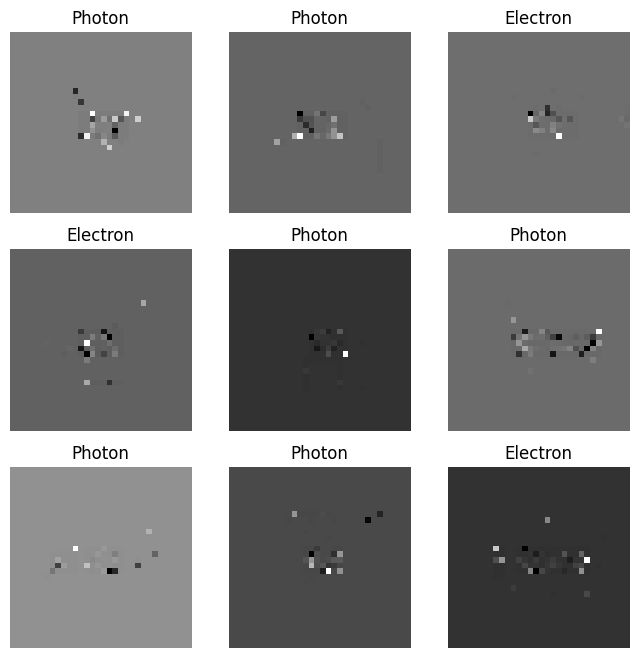

In [ ]:
labels_map = {
    0: "Photon",
    1: "Electron",
}
figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(train_set), size=(1,)).item()
    img, label = train_set[sample_idx][0][1,:,:], train_set[sample_idx][1]
    figure.add_subplot(rows, cols, i)
    plt.title(labels_map[label])
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()

### II.B Plot of Time Channel

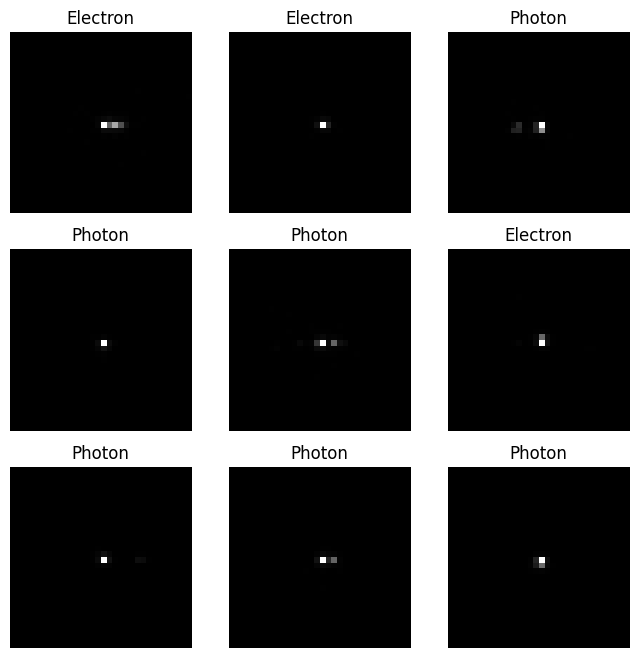

In [ ]:
labels_map = {
    0: "Photon",
    1: "Electron",
}
figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(len(train_set), size=(1,)).item()
    img, label = train_set[sample_idx][0][0,:,:], train_set[sample_idx][1]
    figure.add_subplot(rows, cols, i)
    plt.title(labels_map[label])
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()

## III. Models

### III-A. MLP structure (fully connect neural network)

In [ ]:
class FCNN_CG(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(2 * 32 * 32, 600)
        self.fc2 = nn.Linear(600, 200)
        self.fc3 = nn.Linear(200, 80)
        self.fc4 = nn.Linear(80,2)

    def forward(self, x):
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        x = self.fc4(x)
        return x

In [ ]:
model_FCNN = FCNN_CG().to(device)

### III-B. CNN structure (LeNet type)

The basic structure is similar to Yann Lecun's CNN strcuture (LeNet-5) for MNIST dataset (32$\times$32 pixel version), but we replace the RBF layer of original LeNet-5 with fully connected layer.

In [ ]:
class Lenet5_CG(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(2, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 2)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

We also modify the input layer for single-channel input (energy channel), which is almost same as original LeNet with different output layer.

In [ ]:
class Lenet5_CG(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 2)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [ ]:
model_LeNet = Lenet5_CG().to(device)

### III-C. Simplified ResNet (two ResNet block)

This is a simplified ResNet with only two Residual Block.

In [ ]:
class ResBlock(torch.nn.Module):
    def __init__(self,channels_in):
        super().__init__()
        self.conv1=torch.nn.Conv2d(channels_in,30,5,padding=2)
        self.conv2=torch.nn.Conv2d(30,channels_in,3,padding=1)

    def forward(self,x):
        out=self.conv1(x)
        out=self.conv2(out)
        return F.relu(out+x)

In [ ]:
class ResNet(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1=torch.nn.Conv2d(2,20,5)
        self.conv2=torch.nn.Conv2d(20,15,3)
        self.maxpool=torch.nn.MaxPool2d(2)
        self.resblock1=ResBlock(channels_in=20)
        self.resblock2=ResBlock(channels_in=15)
        self.full_c=torch.nn.Linear(540,2)

    def forward(self,x):
        size=x.shape[0]
        x=F.relu(self.maxpool(self.conv1(x)))
        x=self.resblock1(x)
        x=F.relu(self.maxpool(self.conv2(x)))
        x=self.resblock2(x)
        x=x.view(size,-1)
        x=self.full_c(x)
        return x

The following is for single-channel input (energy channel):

In [ ]:
class ResNet(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1=torch.nn.Conv2d(1,20,5)
        self.conv2=torch.nn.Conv2d(20,15,3)
        self.maxpool=torch.nn.MaxPool2d(2)
        self.resblock1=ResBlock(channels_in=20)
        self.resblock2=ResBlock(channels_in=15)
        self.full_c=torch.nn.Linear(540,2)

    def forward(self,x):
        size=x.shape[0]
        x=F.relu(self.maxpool(self.conv1(x)))
        x=self.resblock1(x)
        x=F.relu(self.maxpool(self.conv2(x)))
        x=self.resblock2(x)
        x=x.view(size,-1)
        x=self.full_c(x)
        return x

In [ ]:
model_Simple_ResNet = ResNet().to(device)

### III-D Pre-trained ResNet18

In [ ]:
# Pre-trained ResNet18
model_ResNet18 = torchvision.models.resnet18(pretrained=True).to(device)
in_features = model_ResNet18.fc.in_features
model_ResNet18.fc = nn.Linear(in_features, 2, device=device)

/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

### III-E. Pre-trained VGG16

In [ ]:
# pre-trained
model_VGG16 = torchvision.models.vgg16(weights=torchvision.models.VGG16_Weights).to(device)

/usr/local/lib/python3.9/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
# without pre-trained parameters
model_VGG16 = torchvision.models.vgg16().to(device)

In [ ]:
in_features = model_VGG16.classifier[6].in_features
model_VGG16.classifier[6] = nn.Linear(in_features, 2, device=device)

### III-F. Pre-trained ViT (Vision Transformer)

In [ ]:
model_ViT = torchvision.models.vit_b_16(weights=torchvision.models.ViT_B_16_Weights.IMAGENET1K_V1).to(device)
in_features = model_ViT.heads.head.in_features
model_ViT.heads.head = nn.Linear(in_features, 2, device=device)

Downloading: "https://download.pytorch.org/models/vit_b_16-c867db91.pth" to /root/.cache/torch/hub/checkpoints/vit_b_16-c867db91.pth


  0%|          | 0.00/330M [00:00<?, ?B/s]

In [ ]:
model_ViT = torchvision.models.vit_b_16().to(device)
in_features = model_ViT.heads.head.in_features
model_ViT.heads.head = nn.Linear(in_features, 2, device=device)

## IV. Train and Test Function

Train Loop Function

In [ ]:
def train_loop(dataloader, model, loss_fn, optimizer):
    model.train()
    size = len(dataloader.dataset)
    running_loss = 0.
    #total_sample = 0
    for batch_i, data in enumerate(dataloader):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data[0].to(device), data[1].to(device)
        
        # zero the parameter gradients
        optimizer.zero_grad()
        
        # Compute prediction and loss
        outputs = model(inputs)
        loss = loss_fn(outputs, labels)
        
        # Backpropagation
        loss.backward()
        optimizer.step()
        
        # print statistics
        running_loss += loss.item()
        num_batch_print = 200
        if batch_i % num_batch_print == num_batch_print - 1:
            current = (batch_i + 1) * len(inputs)
            print(f'batch: [{batch_i + 1:5d}], loss: {running_loss / num_batch_print:.3f}')
            print(f'temporary loss: {loss.item():>7f} | [{current:>5d}/{size:>5d}]')
            running_loss = 0

Test Loop Function

In [ ]:
def test_loop_Entropy(dataloader, model, loss_fn):
    model.eval()
    #size = len(dataloader.dataset)
    num_batches = len(dataloader)
    
    test_loss, correct = 0, 0
    total = 0
    
    with torch.no_grad():
        for data in dataloader:
            # get the inputs for test dataset
            images, labels = data[0].to(device), data[1].to(device)
            
            # calculate the outputs
            outputs = model(images)
            
            # classify which class the output in
            _, predicted = torch.max(outputs.data, 1)
            #_, labels_value = torch.max(labels.data, 1)
            
            # obtain the statistics of test loss and correctness
            test_loss += loss_fn(outputs, labels).item()
            correct += (predicted == labels).sum().item() 
            #correct += (predicted == labels_value).sum().item() 
            total += labels.size(0)

    print(f"Test Error: \n Accuracy: {(100 * correct / total):>0.1f}%")
    print(f"Avg loss: {test_loss / num_batches:>8f} \n")

Classification Probability Function for ROC-AUC calculation

In [ ]:
def test_loop_prob(dataloader, model):
    model.eval()
    #size = len(dataloader.dataset)
    num_batches = len(dataloader)
    
    total_prob = list()
    total_label = list()
    i = 0
    with torch.no_grad():
        for (i, data) in enumerate(dataloader):
            # get the inputs for test dataset
            images, labels = data[0].to(device), data[1].to(device)
            
            # calculate the outputs
            outputs = model(images)
            probabilities = F.softmax(outputs, dim=1)[:, 1]
            
            total_prob += torch.Tensor.cpu(probabilities).numpy().tolist()
            
            total_label += torch.Tensor.cpu(labels).numpy().tolist()
            
            if i % 25 == 0:
                print(f"Process: {i/num_batches*100}\%")
    return np.array(total_prob), np.array(total_label)

## V. Training and Evaluation

### Loss Function

In [ ]:
criterion = nn.CrossEntropyLoss()

### V-A. MLP results

Batch size: 500

Training on: T4 GPU

Initial Learning Rate: 1e-2

Optimizer: Adam

Test Accuracy ~ 66% - 67% (too many epoches result in overfitting)

#### Training and Accuracy (MLP)

In [ ]:
time_start = time.time()
for t in range( 5 ):
    print(f"-------------Epoch {t+1}-------------")
    #optimizer = optim.SGD(model.parameters(), lr=lr_list[t], momentum=0.9)
    optimizer = optim.Adam(model_FCNN.parameters(), lr=1e-2)
    train_loop(train_loader, model_FCNN, criterion, optimizer)
    test_loop_Entropy(test_loader, model_FCNN, criterion)
print("Done!")
time_end = time.time()
print("Time Consumption: ", time_end - time_start)

-------------Epoch 1-------------
batch: [  200], loss: 0.667
temporary loss: 0.653372 | [100000/448200]
batch: [  400], loss: 0.649
temporary loss: 0.635558 | [200000/448200]
batch: [  600], loss: 0.644
temporary loss: 0.623494 | [300000/448200]
batch: [  800], loss: 0.643
temporary loss: 0.673956 | [400000/448200]
Test Error: 
 Accuracy: 63.7%
Avg loss: 0.640869 

-------------Epoch 2-------------
batch: [  200], loss: 0.631
temporary loss: 0.635889 | [100000/448200]
batch: [  400], loss: 0.629
temporary loss: 0.654856 | [200000/448200]
batch: [  600], loss: 0.625
temporary loss: 0.610077 | [300000/448200]
batch: [  800], loss: 0.618
temporary loss: 0.636315 | [400000/448200]
Test Error: 
 Accuracy: 66.3%
Avg loss: 0.620013 

-------------Epoch 3-------------
batch: [  200], loss: 0.595
temporary loss: 0.583819 | [100000/448200]
batch: [  400], loss: 0.596
temporary loss: 0.574251 | [200000/448200]
batch: [  600], loss: 0.593
temporary loss: 0.580394 | [300000/448200]
batch: [  800],

We find that the model starts to overfit at Epoch 4.

#### ROC curve and AUC score (MLP)

In [ ]:
total_prob_FCNN, total_label_FCNN = test_loop_prob(test_loader, model_FCNN)
fpr, tpr, thresholds = metrics.roc_curve(total_label_FCNN, total_prob_FCNN)
FCNN_AUC_1 = metrics.roc_auc_score(total_label_FCNN, total_prob_FCNN)

Process: 0.0\%
Process: 25.0\%
Process: 50.0\%
Process: 75.0\%


In [ ]:
print("The ROC-AUC score of FCNN is:", FCNN_AUC_1)

The ROC-AUC score of FCNN is: 0.7162920619873487


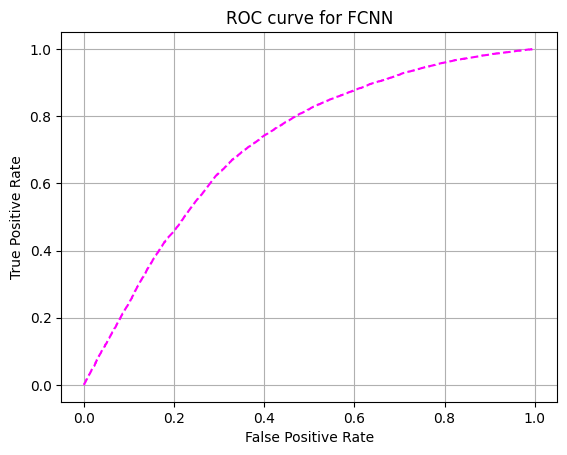

In [ ]:
plt.plot(fpr, tpr, "--", color="magenta")
#plt.plot([0,1],[0,1],"--")
plt.grid()
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC curve for FCNN")
plt.show()

### V-B. CNN results

Batch size: 500

Training on: T4 GPU

Learning Rate: 1e-2 (5 epoch), 1e-3 (3 epoch), 1e-4 (2 epoch) 

Optimizer: Adam

Test Accuracy ~ 71.9%

#### Training and Accuracy (LeNet)

In [ ]:
lr_list = [1e-2]*5 + [1e-3]*3 + [1e-4]*2

In [ ]:
time_start = time.time()
for t in range( len(lr_list) ):
    print(f"-------------Epoch {t+1}-------------")
    #optimizer = optim.SGD(model.parameters(), lr=lr_list[t], momentum=0.9)
    optimizer = optim.Adam(model_LeNet.parameters(), lr=lr_list[t])
    train_loop(train_loader, model_LeNet, criterion, optimizer)
    test_loop_Entropy(test_loader, model_LeNet, criterion)
print("Done!")
time_end = time.time()
print("Time Consumption: ", time_end - time_start)

-------------Epoch 1-------------
batch: [  200], loss: 0.667
temporary loss: 0.659411 | [100000/448200]
batch: [  400], loss: 0.645
temporary loss: 0.671905 | [200000/448200]
batch: [  600], loss: 0.625
temporary loss: 0.614612 | [300000/448200]
batch: [  800], loss: 0.609
temporary loss: 0.578160 | [400000/448200]
Test Error: 
 Accuracy: 68.7%
Avg loss: 0.596107 

-------------Epoch 2-------------
batch: [  200], loss: 0.594
temporary loss: 0.550116 | [100000/448200]
batch: [  400], loss: 0.590
temporary loss: 0.589140 | [200000/448200]
batch: [  600], loss: 0.589
temporary loss: 0.565250 | [300000/448200]
batch: [  800], loss: 0.587
temporary loss: 0.573252 | [400000/448200]
Test Error: 
 Accuracy: 70.4%
Avg loss: 0.580446 

-------------Epoch 3-------------
batch: [  200], loss: 0.585
temporary loss: 0.557440 | [100000/448200]
batch: [  400], loss: 0.582
temporary loss: 0.583403 | [200000/448200]
batch: [  600], loss: 0.581
temporary loss: 0.582290 | [300000/448200]
batch: [  800],

#### ROC and AUC (LeNet)

In [ ]:
total_prob_LeNet, total_label_LeNet = test_loop_prob(test_loader, model_LeNet)
fpr, tpr, thresholds = metrics.roc_curve(total_label_LeNet, total_prob_LeNet)
LeNet_AUC_1 = metrics.roc_auc_score(total_label_LeNet, total_prob_LeNet)

Process: 0.0\%
Process: 25.0\%
Process: 50.0\%
Process: 75.0\%


In [ ]:
print("The ROC-AUC score of LeNet is:", LeNet_AUC_1)

The ROC-AUC score of LeNet is: 0.7781870042368337


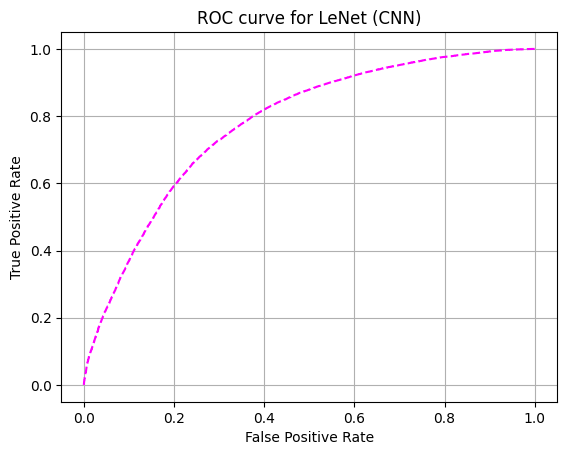

In [ ]:
plt.plot(fpr, tpr, "--", color="magenta")
#plt.plot([0,1],[0,1],"--")
plt.grid()
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC curve for LeNet (CNN)")
plt.show()

### V-C. Simplified ResNet results

Batch size: 500

Training on: T4 GPU

Learning Rate: 1e-3 (6 epoch), 1e-4 (6 epoch) 

Optimizer: Adam

Test Accuracy ~ 72.1%

#### Training and Accuracy (Simplified ResNet)

In [ ]:
lr_list = [1e-3]*6 + [1e-4]*3
time_start = time.time()
# Pre-trained ResNet training
for t in range( len(lr_list) ):
    print(f"-------------Epoch {t+1}-------------")
    #optimizer = optim.SGD(model.parameters(), lr=lr_list[t], momentum=0.9)
    optimizer = optim.Adam(model_Simple_ResNet.parameters(), lr=lr_list[t])
    train_loop(train_loader, model_Simple_ResNet, criterion, optimizer)
    test_loop_Entropy(test_loader, model_Simple_ResNet, criterion)
print("Done!")
time_end = time.time()
print("Time Consumption",time_end-time_start)

-------------Epoch 1-------------
batch: [  200], loss: 0.669
temporary loss: 0.672653 | [100000/448200]
batch: [  400], loss: 0.650
temporary loss: 0.642586 | [200000/448200]
batch: [  600], loss: 0.640
temporary loss: 0.629567 | [300000/448200]
batch: [  800], loss: 0.624
temporary loss: 0.602571 | [400000/448200]
Test Error: 
 Accuracy: 67.3%
Avg loss: 0.609951 

-------------Epoch 2-------------
batch: [  200], loss: 0.609
temporary loss: 0.648338 | [100000/448200]
batch: [  400], loss: 0.600
temporary loss: 0.589700 | [200000/448200]
batch: [  600], loss: 0.598
temporary loss: 0.567832 | [300000/448200]
batch: [  800], loss: 0.589
temporary loss: 0.603977 | [400000/448200]
Test Error: 
 Accuracy: 69.7%
Avg loss: 0.585450 

-------------Epoch 3-------------
batch: [  200], loss: 0.586
temporary loss: 0.592500 | [100000/448200]
batch: [  400], loss: 0.580
temporary loss: 0.572234 | [200000/448200]
batch: [  600], loss: 0.583
temporary loss: 0.619365 | [300000/448200]
batch: [  800],

In [ ]:
lr_list = [1e-4]*3
time_start = time.time()
# Pre-trained ResNet training
for t in range( len(lr_list) ):
    print(f"-------------Epoch {t+1}-------------")
    #optimizer = optim.SGD(model.parameters(), lr=lr_list[t], momentum=0.9)
    optimizer = optim.Adam(model_Simple_ResNet.parameters(), lr=lr_list[t])
    train_loop(train_loader, model_Simple_ResNet, criterion, optimizer)
    test_loop_Entropy(test_loader, model_Simple_ResNet, criterion)
print("Done!")
time_end = time.time()
print("Time Consumption",time_end-time_start)

-------------Epoch 1-------------
batch: [  200], loss: 0.552
temporary loss: 0.545469 | [100000/448200]
batch: [  400], loss: 0.550
temporary loss: 0.557074 | [200000/448200]
batch: [  600], loss: 0.552
temporary loss: 0.510268 | [300000/448200]
batch: [  800], loss: 0.552
temporary loss: 0.536746 | [400000/448200]
Test Error: 
 Accuracy: 72.1%
Avg loss: 0.557619 

-------------Epoch 2-------------
batch: [  200], loss: 0.551
temporary loss: 0.578680 | [100000/448200]
batch: [  400], loss: 0.549
temporary loss: 0.565552 | [200000/448200]
batch: [  600], loss: 0.550
temporary loss: 0.533266 | [300000/448200]
batch: [  800], loss: 0.551
temporary loss: 0.551256 | [400000/448200]
Test Error: 
 Accuracy: 72.1%
Avg loss: 0.556805 

-------------Epoch 3-------------
batch: [  200], loss: 0.551
temporary loss: 0.575537 | [100000/448200]
batch: [  400], loss: 0.550
temporary loss: 0.556270 | [200000/448200]
batch: [  600], loss: 0.549
temporary loss: 0.543590 | [300000/448200]
batch: [  800],

#### ROC and AUC (Simplified ResNet)

In [ ]:
total_prob_Simple_ResNet, total_label_Simple_ResNet = test_loop_prob(test_loader, model_Simple_ResNet)
fpr, tpr, thresholds = metrics.roc_curve(total_label_Simple_ResNet, total_prob_Simple_ResNet)
Simple_ResNet_AUC_1 = metrics.roc_auc_score(total_label_Simple_ResNet, total_prob_Simple_ResNet)

Process: 0.0\%
Process: 25.0\%
Process: 50.0\%
Process: 75.0\%


In [ ]:
print("The ROC-AUC score of LeNet is:", Simple_ResNet_AUC_1)

The ROC-AUC score of LeNet is: 0.7857869000822217


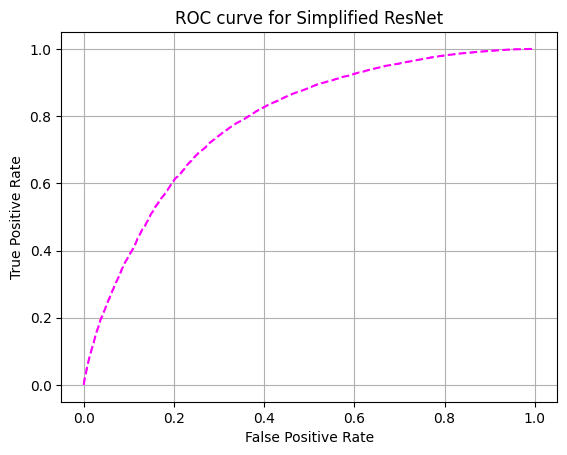

In [ ]:
plt.plot(fpr, tpr, "--", color="magenta")
#plt.plot([0,1],[0,1],"--")
plt.grid()
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC curve for Simplified ResNet")
plt.show()

### V-D. Pre-trained ResNet-18 results (BEST performance)

Batch size: 500

Training on: A100 GPU

Learning Rate: 1e-2 (5 epoch), 1e-3 (3 epoch) 

Optimizer: Adam

Test Accuracy ~ 74.0%

#### New Dataset (Pre-trained ResNet-18)

In [ ]:
train_set = MyDataset(shuffle_list=shuffle_list, train=True, transform=my_transform_pretrained)
train_loader =  DataLoader(train_set, batch_size=500, shuffle=True)

In [ ]:
test_set = MyDataset(shuffle_list=shuffle_list, train=False, transform=my_transform_pretrained)
test_loader =  DataLoader(test_set, batch_size=500, shuffle=False)

#### Training and Accuracy (Pre-trained ResNet-18)

In [ ]:
lr_list = [1e-2]*5
time_start = time.time()
# Pre-trained ResNet training
for t in range( len(lr_list) ):
    print(f"-------------Epoch {t+1}-------------")
    #optimizer = optim.SGD(model.parameters(), lr=lr_list[t], momentum=0.9)
    optimizer = optim.Adam(model_ResNet18.parameters(), lr=lr_list[t])
    train_loop(train_loader, model_ResNet18, criterion, optimizer)
    test_loop_Entropy(test_loader, model_ResNet18, criterion)
print("Done!")
time_end = time.time()
print("Time Consumption",time_end-time_start)

-------------Epoch 1-------------
batch: [  200], loss: 0.740
temporary loss: 0.674751 | [100000/448200]
batch: [  400], loss: 0.671
temporary loss: 0.665364 | [200000/448200]
batch: [  600], loss: 0.629
temporary loss: 0.614760 | [300000/448200]
batch: [  800], loss: 0.587
temporary loss: 0.572252 | [400000/448200]
Test Error: 
 Accuracy: 71.0%
Avg loss: 0.571762 

-------------Epoch 2-------------
batch: [  200], loss: 0.580
temporary loss: 0.548804 | [100000/448200]
batch: [  400], loss: 0.566
temporary loss: 0.561248 | [200000/448200]
batch: [  600], loss: 0.563
temporary loss: 0.531189 | [300000/448200]
batch: [  800], loss: 0.560
temporary loss: 0.590924 | [400000/448200]
Test Error: 
 Accuracy: 72.3%
Avg loss: 0.559428 

-------------Epoch 3-------------
batch: [  200], loss: 0.559
temporary loss: 0.533297 | [100000/448200]
batch: [  400], loss: 0.558
temporary loss: 0.561796 | [200000/448200]
batch: [  600], loss: 0.556
temporary loss: 0.555340 | [300000/448200]
batch: [  800],

In [ ]:
lr_list = [1e-3]*3
time_start = time.time()
# Pre-trained ResNet training
for t in range( len(lr_list) ):
    print(f"-------------Epoch {t+1}-------------")
    #optimizer = optim.SGD(model.parameters(), lr=lr_list[t], momentum=0.9)
    optimizer = optim.Adam(model_ResNet18.parameters(), lr=lr_list[t])
    train_loop(train_loader, model_ResNet18, criterion, optimizer)
    test_loop_Entropy(test_loader, model_ResNet18, criterion)
print("Done!")
time_end = time.time()
print("Time Consumption",time_end-time_start)

-------------Epoch 1-------------
batch: [  200], loss: 0.535
temporary loss: 0.561012 | [100000/448200]
batch: [  400], loss: 0.533
temporary loss: 0.541025 | [200000/448200]
batch: [  600], loss: 0.536
temporary loss: 0.547842 | [300000/448200]
batch: [  800], loss: 0.532
temporary loss: 0.537174 | [400000/448200]
Test Error: 
 Accuracy: 74.0%
Avg loss: 0.530638 

-------------Epoch 2-------------
batch: [  200], loss: 0.529
temporary loss: 0.502378 | [100000/448200]
batch: [  400], loss: 0.532
temporary loss: 0.556422 | [200000/448200]
batch: [  600], loss: 0.533
temporary loss: 0.553168 | [300000/448200]
batch: [  800], loss: 0.530
temporary loss: 0.554753 | [400000/448200]
Test Error: 
 Accuracy: 74.0%
Avg loss: 0.530979 

-------------Epoch 3-------------
batch: [  200], loss: 0.531
temporary loss: 0.545476 | [100000/448200]
batch: [  400], loss: 0.529
temporary loss: 0.559358 | [200000/448200]
batch: [  600], loss: 0.530
temporary loss: 0.512510 | [300000/448200]
batch: [  800],

In the initial test loop function, I forgot to include "model.eval()" for pre-trained models (with LayerNorm layers and Dropout layers). Therefore, the following is the results with "model.eval()".

In [ ]:
lr_list = [1e-2]*5 + [1e-3]*6
time_start = time.time()
# Pre-trained ResNet training
for t in range( len(lr_list) ):
    print(f"-------------Epoch {t+1}-------------")
    #optimizer = optim.SGD(model.parameters(), lr=lr_list[t], momentum=0.9)
    optimizer = optim.Adam(model_ResNet18.parameters(), lr=lr_list[t])
    train_loop(train_loader, model_ResNet18, criterion, optimizer)
    test_loop_Entropy(test_loader, model_ResNet18, criterion)
print("Done!")
time_end = time.time()
print("Time Consumption",time_end-time_start)

-------------Epoch 1-------------
batch: [  200], loss: 0.693
temporary loss: 0.635792 | [100000/448200]
batch: [  400], loss: 0.629
temporary loss: 0.609220 | [200000/448200]
batch: [  600], loss: 0.593
temporary loss: 0.593756 | [300000/448200]
batch: [  800], loss: 0.581
temporary loss: 0.570294 | [400000/448200]
Test Error: 
 Accuracy: 70.0%
Avg loss: 0.587213 

-------------Epoch 2-------------
batch: [  200], loss: 0.590
temporary loss: 0.578804 | [100000/448200]
batch: [  400], loss: 0.570
temporary loss: 0.588556 | [200000/448200]
batch: [  600], loss: 0.566
temporary loss: 0.585767 | [300000/448200]
batch: [  800], loss: 0.561
temporary loss: 0.558714 | [400000/448200]
Test Error: 
 Accuracy: 51.8%
Avg loss: 0.901725 

-------------Epoch 3-------------
batch: [  200], loss: 0.561
temporary loss: 0.567318 | [100000/448200]
batch: [  400], loss: 0.558
temporary loss: 0.544346 | [200000/448200]
batch: [  600], loss: 0.555
temporary loss: 0.555401 | [300000/448200]
batch: [  800],

#### ROC and AUC (Pre-trained ResNet-18)

In [ ]:
total_prob_ResNet18, total_label_ResNet18 = test_loop_prob(test_loader, model_ResNet18)
fpr, tpr, thresholds = metrics.roc_curve(total_label_ResNet18, total_prob_ResNet18)
ResNet18_AUC_1 = metrics.roc_auc_score(total_label_ResNet18, total_prob_ResNet18)

Process: 0.0\%
Process: 25.0\%
Process: 50.0\%
Process: 75.0\%


In [ ]:
print("The ROC-AUC score of Pre-trained ResNet-18 is:", ResNet18_AUC_1)

The ROC-AUC score of Pre-trained ResNet-18 is: 0.812007317729629


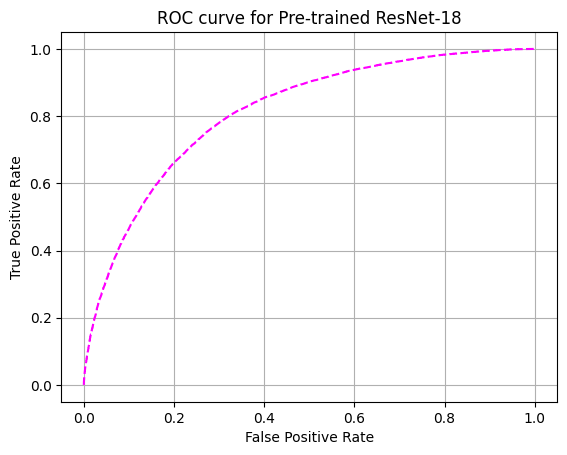

In [ ]:
plt.plot(fpr, tpr, "--", color="magenta")
#plt.plot([0,1],[0,1],"--")
plt.grid()
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC curve for Pre-trained ResNet-18")
plt.show()

### V-E. Pre-trained VGG 16

Batch size: 200

Training on: A100 GPU

Learning Ratea: 1e-2, 1e-3, 1e-4

Optimizer: Adam

Test Accuracy ~ 50.3% (alomost equal to coin tosser); no need to calculate ROC-AUC

The training is very slow and computational expensive.

#### New Dataloader with smaller batches

In [ ]:
#train_set = MyDataset(shuffle_list=shuffle_list, train=True, transform=my_transform_pretrained)
train_loader =  DataLoader(train_set, batch_size=200, shuffle=True)

In [ ]:
#test_set = MyDataset(shuffle_list=shuffle_list, train=False, transform=my_transform_pretrained)
test_loader =  DataLoader(test_set, batch_size=200, shuffle=False)

#### Training and Accuracy (Pre-trained VGG16)

In [ ]:
lr_list = [1e-2]
time_start = time.time()
# Pre-trained ResNet training
for t in range( len(lr_list) ):
    print(f"-------------Epoch {t+1}-------------")
    #optimizer = optim.SGD(model.parameters(), lr=lr_list[t], momentum=0.9)
    optimizer = optim.Adam(model_VGG16.parameters(), lr=lr_list[t])
    train_loop(train_loader, model_VGG16, criterion, optimizer)
    test_loop_Entropy(test_loader, model_VGG16, criterion)
print("Done!")
time_end = time.time()
print("Time Consumption",time_end-time_start)

-------------Epoch 1-------------
batch: [  200], loss: 30495409.041
temporary loss: 0.692964 | [40000/448200]
batch: [  400], loss: 43.491
temporary loss: 0.693337 | [80000/448200]
batch: [  600], loss: 4.223
temporary loss: 0.693330 | [120000/448200]
batch: [  800], loss: 1.129
temporary loss: 0.693144 | [160000/448200]
batch: [ 1000], loss: 1.060
temporary loss: 0.692434 | [200000/448200]
batch: [ 1200], loss: 0.730
temporary loss: 0.693299 | [240000/448200]
batch: [ 1400], loss: 0.697
temporary loss: 0.693155 | [280000/448200]
batch: [ 1600], loss: 0.701
temporary loss: 0.694630 | [320000/448200]
batch: [ 1800], loss: 0.878
temporary loss: 0.693752 | [360000/448200]
batch: [ 2000], loss: 0.743
temporary loss: 0.693450 | [400000/448200]
batch: [ 2200], loss: 0.821
temporary loss: 0.693645 | [440000/448200]
Test Error: 
 Accuracy: 49.7%
Avg loss: 0.693232 

Done!
Time Consumption 992.9338898658752


In [ ]:
lr_list = [1e-3, 1e-4]
time_start = time.time()
# Pre-trained ResNet training
for t in range( len(lr_list) ):
    print(f"-------------Epoch {t+1}-------------")
    #optimizer = optim.SGD(model.parameters(), lr=lr_list[t], momentum=0.9)
    optimizer = optim.Adam(model_VGG16.parameters(), lr=lr_list[t])
    train_loop(train_loader, model_VGG16, criterion, optimizer)
    test_loop_Entropy(test_loader, model_VGG16, criterion)
print("Done!")
time_end = time.time()
print("Time Consumption",time_end-time_start)

-------------Epoch 1-------------
batch: [  200], loss: 0.693
temporary loss: 0.693501 | [40000/448200]
batch: [  400], loss: 0.717
temporary loss: 0.692994 | [80000/448200]
batch: [  600], loss: 0.703
temporary loss: 0.692833 | [120000/448200]
batch: [  800], loss: 0.693
temporary loss: 0.692997 | [160000/448200]
batch: [ 1000], loss: 0.693
temporary loss: 0.693422 | [200000/448200]
batch: [ 1200], loss: 0.693
temporary loss: 0.693232 | [240000/448200]
batch: [ 1400], loss: 0.693
temporary loss: 0.693183 | [280000/448200]
batch: [ 1600], loss: 0.693
temporary loss: 0.693109 | [320000/448200]
batch: [ 1800], loss: 0.693
temporary loss: 0.693134 | [360000/448200]
batch: [ 2000], loss: 0.693
temporary loss: 0.693840 | [400000/448200]
batch: [ 2200], loss: 0.693
temporary loss: 0.693116 | [440000/448200]
Test Error: 
 Accuracy: 49.7%
Avg loss: 0.693163 

-------------Epoch 2-------------
batch: [  200], loss: 0.693
temporary loss: 0.693064 | [40000/448200]
batch: [  400], loss: 0.693
temp

### V-F. VGG 166 (not pre-trained) results

Batch size: 200

Training on: A100 GPU

Learning Rate: 1e-3

Optimizer: Adam

Test Accuracy ~ 50.3% (almost qual to coin tosser)

#### Training and Accuracy (VGG16 without pre-trained parameters)

In [ ]:
lr_list = [1e-3]
time_start = time.time()
# Pre-trained ResNet training
for t in range( len(lr_list) ):
    print(f"-------------Epoch {t+1}-------------")
    #optimizer = optim.SGD(model.parameters(), lr=lr_list[t], momentum=0.9)
    optimizer = optim.Adam(model_VGG16.parameters(), lr=lr_list[t])
    train_loop(train_loader, model_VGG16, criterion, optimizer)
    test_loop_Entropy(test_loader, model_VGG16, criterion)
print("Done!")
time_end = time.time()
print("Time Consumption",time_end-time_start)

-------------Epoch 1-------------
batch: [  200], loss: 0.712
temporary loss: 0.691462 | [40000/448200]
batch: [  400], loss: 0.693
temporary loss: 0.689889 | [80000/448200]
batch: [  600], loss: 0.693
temporary loss: 0.693212 | [120000/448200]
batch: [  800], loss: 0.693
temporary loss: 0.693324 | [160000/448200]
batch: [ 1000], loss: 0.693
temporary loss: 0.693122 | [200000/448200]
batch: [ 1200], loss: 0.693
temporary loss: 0.693236 | [240000/448200]
batch: [ 1400], loss: 0.693
temporary loss: 0.693503 | [280000/448200]
batch: [ 1600], loss: 0.693
temporary loss: 0.692238 | [320000/448200]
batch: [ 1800], loss: 0.693
temporary loss: 0.693481 | [360000/448200]
batch: [ 2000], loss: 0.693
temporary loss: 0.692670 | [400000/448200]
batch: [ 2200], loss: 0.693
temporary loss: 0.693368 | [440000/448200]
Test Error: 
 Accuracy: 50.3%
Avg loss: 0.693123 

Done!
Time Consumption 990.8063123226166


### V-G. Pre-trained ViT results

Batch size: 200

Training on: A100 GPU

Learning Rate: 1e-3 (5 epoch), 1e-4 (3 epoch)

Optimizer: Adam

Test Accuracy ~ 72.5% (underfit, not well-trained yet) 

Time: The training of ViT is very slow and computational expensive. Each epoch will cost about 1 hour on A100 GPU.

#### Training and Accuracy (Pre-trained ViT)

In [ ]:
lr_list = [1e-3]
time_start = time.time()
# Pre-trained ResNet training
for t in range( len(lr_list) ):
    print(f"-------------Epoch {t+1}-------------")
    #optimizer = optim.SGD(model.parameters(), lr=lr_list[t], momentum=0.9)
    optimizer = optim.Adam(model_ViT.parameters(), lr=lr_list[t])
    train_loop(train_loader, model_ViT, criterion, optimizer)
    test_loop_Entropy(test_loader, model_ViT, criterion)
print("Done!")
time_end = time.time()
print("Time Consumption",time_end-time_start)

-------------Epoch 1-------------
batch: [  200], loss: 0.746
temporary loss: 0.693299 | [40000/448200]
batch: [  400], loss: 0.699
temporary loss: 0.691458 | [80000/448200]
batch: [  600], loss: 0.684
temporary loss: 0.674643 | [120000/448200]
batch: [  800], loss: 0.670
temporary loss: 0.669602 | [160000/448200]
batch: [ 1000], loss: 0.657
temporary loss: 0.672156 | [200000/448200]
batch: [ 1200], loss: 0.645
temporary loss: 0.625073 | [240000/448200]
batch: [ 1400], loss: 0.637
temporary loss: 0.641013 | [280000/448200]
batch: [ 1600], loss: 0.628
temporary loss: 0.642921 | [320000/448200]
batch: [ 1800], loss: 0.625
temporary loss: 0.601461 | [360000/448200]
batch: [ 2000], loss: 0.617
temporary loss: 0.572669 | [400000/448200]
batch: [ 2200], loss: 0.615
temporary loss: 0.570742 | [440000/448200]
Test Error: 
 Accuracy: 68.4%
Avg loss: 0.602019 

Done!
Time Consumption 3339.724937438965


In [ ]:
path = "./gdrive/MyDrive/CMS_model/ViT_task1_weights.pth"
torch.save(model_ViT.state_dict(), path)

In [ ]:
path = "./gdrive/MyDrive/CMS_model/ViT_task1_weights.pth"
model_ViT.load_state_dict( torch.load(path) )

<All keys matched successfully>

In [ ]:
test_loop_Entropy(test_loader, model_ViT, criterion)

Test Error: 
 Accuracy: 68.2%
Avg loss: 0.603492 



In [ ]:
path2 = "./gdrive/MyDrive/CMS_model/ViT_task1_weights_02.pth"
lr_list = [1e-3] * 4
time_start = time.time()
# Pre-trained ResNet training
for t in range( len(lr_list) ):
    print(f"-------------Epoch {t+1}-------------")
    #optimizer = optim.SGD(model.parameters(), lr=lr_list[t], momentum=0.9)
    optimizer = optim.Adam(model_ViT.parameters(), lr=lr_list[t])
    train_loop(train_loader, model_ViT, criterion, optimizer)
    test_loop_Entropy(test_loader, model_ViT, criterion)
print("Done!")
time_end = time.time()
torch.save(model_ViT.state_dict(), path2)
print("Time Consumption",time_end-time_start)

-------------Epoch 1-------------
batch: [  200], loss: 0.616
temporary loss: 0.600729 | [40000/448200]
batch: [  400], loss: 0.614
temporary loss: 0.564398 | [80000/448200]
batch: [  600], loss: 0.613
temporary loss: 0.602672 | [120000/448200]
batch: [  800], loss: 0.602
temporary loss: 0.658477 | [160000/448200]
batch: [ 1000], loss: 0.606
temporary loss: 0.604870 | [200000/448200]
batch: [ 1200], loss: 0.602
temporary loss: 0.615562 | [240000/448200]
batch: [ 1400], loss: 0.599
temporary loss: 0.591999 | [280000/448200]
batch: [ 1600], loss: 0.596
temporary loss: 0.579711 | [320000/448200]
batch: [ 1800], loss: 0.597
temporary loss: 0.590777 | [360000/448200]
batch: [ 2000], loss: 0.599
temporary loss: 0.614489 | [400000/448200]
batch: [ 2200], loss: 0.596
temporary loss: 0.562108 | [440000/448200]
Test Error: 
 Accuracy: 68.8%
Avg loss: 0.596738 

-------------Epoch 2-------------
batch: [  200], loss: 0.597
temporary loss: 0.638775 | [40000/448200]
batch: [  400], loss: 0.593
temp

In [ ]:
path3 = "./gdrive/MyDrive/CMS_model/ViT_task1_weights_03.pth"
lr_list = [1e-4] * 3
time_start = time.time()
# Pre-trained ResNet training
for t in range( len(lr_list) ):
    print(f"-------------Epoch {t+1}-------------")
    #optimizer = optim.SGD(model.parameters(), lr=lr_list[t], momentum=0.9)
    optimizer = optim.Adam(model_ViT.parameters(), lr=lr_list[t])
    train_loop(train_loader, model_ViT, criterion, optimizer)
    test_loop_Entropy(test_loader, model_ViT, criterion)
print("Done!")
time_end = time.time()
torch.save(model_ViT.state_dict(), path3)
print("Time Consumption",time_end-time_start)

-------------Epoch 1-------------
batch: [  200], loss: 0.567
temporary loss: 0.634036 | [40000/448200]
batch: [  400], loss: 0.560
temporary loss: 0.592325 | [80000/448200]
batch: [  600], loss: 0.560
temporary loss: 0.510238 | [120000/448200]
batch: [  800], loss: 0.560
temporary loss: 0.561333 | [160000/448200]
batch: [ 1000], loss: 0.562
temporary loss: 0.588687 | [200000/448200]
batch: [ 1200], loss: 0.560
temporary loss: 0.548363 | [240000/448200]
batch: [ 1400], loss: 0.560
temporary loss: 0.533402 | [280000/448200]
batch: [ 1600], loss: 0.560
temporary loss: 0.582457 | [320000/448200]
batch: [ 1800], loss: 0.559
temporary loss: 0.528317 | [360000/448200]
batch: [ 2000], loss: 0.557
temporary loss: 0.579121 | [400000/448200]
batch: [ 2200], loss: 0.560
temporary loss: 0.567330 | [440000/448200]
Test Error: 
 Accuracy: 72.1%
Avg loss: 0.556552 

-------------Epoch 2-------------
batch: [  200], loss: 0.561
temporary loss: 0.577444 | [40000/448200]
batch: [  400], loss: 0.558
temp

## VI. Further Discussion (better performance ?)

### Correlation between two channels (energy channel and time channel)
CMS data might be very different from image data, although the dimensionality of CMS data is very similar with image data. 
1. Image data: $N_{\text{samples}}\times \text{Channel}\times \text{Height} \times \text{Width}$: There is no strong correlation between three channels of "RGB" images.
2. CMS data: $N_{\text{samples}}\times \text{Channel}\times \text{Height} \times \text{Width}$: The correlation between two channels of CMS data (energy channel and time channel) is unknown.

This is the possible reason why the performance of CNN-based models (including LeNet, ResNet) is not so perfect on this dataset.

Therefore, we try to only use the energy channel for the classification task in the following numeric experiments.

#### Dataset and Dataloader with only the energy channel

In [ ]:
total_X = total_X[:,:,:,:1]

In [ ]:
train_set = MyDataset(shuffle_list=shuffle_list, train=True, transform=my_transform_normal)
train_loader =  DataLoader(train_set, batch_size=500, shuffle=True)

In [ ]:
test_set = MyDataset(shuffle_list=shuffle_list, train=False, transform=my_transform_normal)
test_loader =  DataLoader(test_set, batch_size=500, shuffle=False)

#### Numeric Experiment on Single Channel LeNet

In [ ]:
class Lenet5_single_channel(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 2)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [ ]:
model_LeNet_single = Lenet5_single_channel().to(device)

In [ ]:
lr_list = [1e-2]*5 + [1e-3]*3 + [1e-4]*2

In [ ]:
time_start = time.time()
for t in range( len(lr_list) ):
    print(f"-------------Epoch {t+1}-------------")
    #optimizer = optim.SGD(model.parameters(), lr=lr_list[t], momentum=0.9)
    optimizer = optim.Adam(model_LeNet_single.parameters(), lr=lr_list[t])
    train_loop(train_loader, model_LeNet_single, criterion, optimizer)
    test_loop_Entropy(test_loader, model_LeNet_single, criterion)
print("Done!")
time_end = time.time()
print("Time Consumption: ", time_end - time_start)

-------------Epoch 1-------------
batch: [  200], loss: 0.650
temporary loss: 0.616228 | [100000/448200]
batch: [  400], loss: 0.603
temporary loss: 0.610496 | [200000/448200]
batch: [  600], loss: 0.592
temporary loss: 0.574247 | [300000/448200]
batch: [  800], loss: 0.583
temporary loss: 0.575070 | [400000/448200]
Test Error: 
 Accuracy: 70.9%
Avg loss: 0.579125 

-------------Epoch 2-------------
batch: [  200], loss: 0.581
temporary loss: 0.563609 | [100000/448200]
batch: [  400], loss: 0.578
temporary loss: 0.578217 | [200000/448200]
batch: [  600], loss: 0.573
temporary loss: 0.571977 | [300000/448200]
batch: [  800], loss: 0.571
temporary loss: 0.551068 | [400000/448200]
Test Error: 
 Accuracy: 71.7%
Avg loss: 0.566196 

-------------Epoch 3-------------
batch: [  200], loss: 0.569
temporary loss: 0.618953 | [100000/448200]
batch: [  400], loss: 0.569
temporary loss: 0.557745 | [200000/448200]
batch: [  600], loss: 0.570
temporary loss: 0.578463 | [300000/448200]
batch: [  800],

In [ ]:
total_prob_LeNet_single, total_label_LeNet_single = test_loop_prob(test_loader, model_LeNet_single)
fpr, tpr, thresholds = metrics.roc_curve(total_label_LeNet_single, total_prob_LeNet_single)
LeNet_single_AUC_1 = metrics.roc_auc_score(total_label_LeNet_single, total_prob_LeNet_single)

Process: 0.0\%
Process: 25.0\%
Process: 50.0\%
Process: 75.0\%


In [ ]:
print("The ROC-AUC score of Single Channel LeNet is:", LeNet_single_AUC_1)

The ROC-AUC score of Single Channel LeNet is: 0.7926589426117382


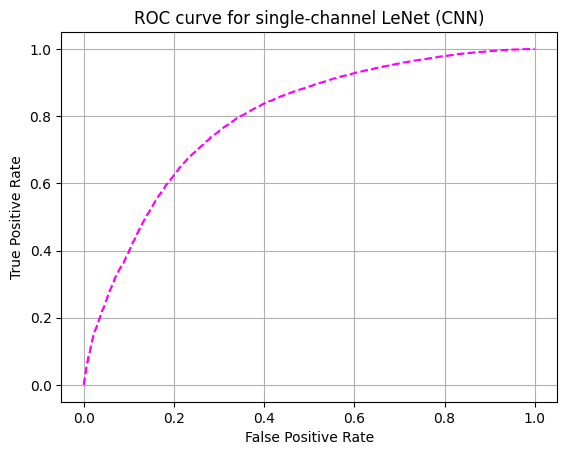

In [ ]:
plt.plot(fpr, tpr, "--", color="magenta")
#plt.plot([0,1],[0,1],"--")
plt.grid()
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC curve for single-channel LeNet (CNN)")
plt.show()

#### Numeric Experiment on Single Channel Simplified ResNet

In [ ]:
class ResNet_single_channel(torch.nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1=torch.nn.Conv2d(1,20,5)
        self.conv2=torch.nn.Conv2d(20,15,3)
        self.maxpool=torch.nn.MaxPool2d(2)
        self.resblock1=ResBlock(channels_in=20)
        self.resblock2=ResBlock(channels_in=15)
        self.full_c=torch.nn.Linear(540,2)

    def forward(self,x):
        size=x.shape[0]
        x=F.relu(self.maxpool(self.conv1(x)))
        x=self.resblock1(x)
        x=F.relu(self.maxpool(self.conv2(x)))
        x=self.resblock2(x)
        x=x.view(size,-1)
        x=self.full_c(x)
        return x

In [ ]:
model_Simple_ResNet_single = ResNet_single_channel().to(device)

In [ ]:
lr_list = [1e-3]*6 + [1e-4]*6
time_start = time.time()
# Pre-trained ResNet training
for t in range( len(lr_list) ):
    print(f"-------------Epoch {t+1}-------------")
    #optimizer = optim.SGD(model.parameters(), lr=lr_list[t], momentum=0.9)
    optimizer = optim.Adam(model_Simple_ResNet_single.parameters(), lr=lr_list[t])
    train_loop(train_loader, model_Simple_ResNet_single, criterion, optimizer)
    test_loop_Entropy(test_loader, model_Simple_ResNet_single, criterion)
print("Done!")
time_end = time.time()
print("Time Consumption",time_end-time_start)

-------------Epoch 1-------------
batch: [  200], loss: 0.666
temporary loss: 0.645053 | [100000/448200]
batch: [  400], loss: 0.626
temporary loss: 0.611690 | [200000/448200]
batch: [  600], loss: 0.600
temporary loss: 0.572057 | [300000/448200]
batch: [  800], loss: 0.596
temporary loss: 0.589399 | [400000/448200]
Test Error: 
 Accuracy: 69.3%
Avg loss: 0.591594 

-------------Epoch 2-------------
batch: [  200], loss: 0.590
temporary loss: 0.568572 | [100000/448200]
batch: [  400], loss: 0.584
temporary loss: 0.557500 | [200000/448200]
batch: [  600], loss: 0.586
temporary loss: 0.560311 | [300000/448200]
batch: [  800], loss: 0.579
temporary loss: 0.558588 | [400000/448200]
Test Error: 
 Accuracy: 70.4%
Avg loss: 0.579351 

-------------Epoch 3-------------
batch: [  200], loss: 0.585
temporary loss: 0.579588 | [100000/448200]
batch: [  400], loss: 0.580
temporary loss: 0.550817 | [200000/448200]
batch: [  600], loss: 0.577
temporary loss: 0.571427 | [300000/448200]
batch: [  800],

In [ ]:
total_prob_Simple_ResNet_single, total_label_Simple_ResNet_single = test_loop_prob(test_loader, model_Simple_ResNet_single)
fpr, tpr, thresholds = metrics.roc_curve(total_label_Simple_ResNet_single, total_prob_Simple_ResNet_single)
Simple_ResNet_single_AUC_1 = metrics.roc_auc_score(total_label_Simple_ResNet_single, total_prob_Simple_ResNet_single)

Process: 0.0\%
Process: 25.0\%
Process: 50.0\%
Process: 75.0\%


In [ ]:
print("The ROC-AUC score of Single Channel Simpified ResNet is:", Simple_ResNet_single_AUC_1)

The ROC-AUC score of Single Channel Simpified ResNet is: 0.7898301730353752


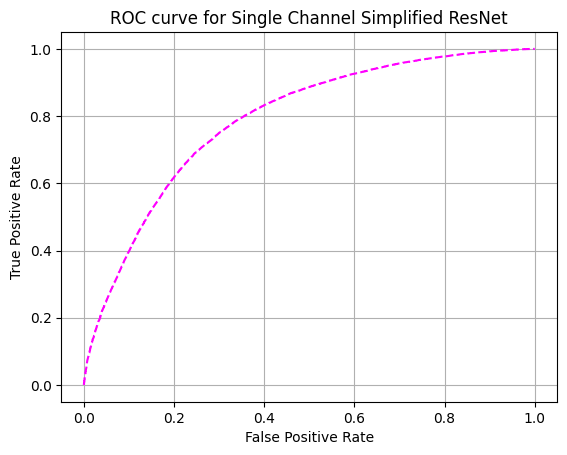

In [ ]:
plt.plot(fpr, tpr, "--", color="magenta")
#plt.plot([0,1],[0,1],"--")
plt.grid()
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC curve for Single Channel Simplified ResNet")
plt.show()

#### Numeric Experiment on Pre-trained ResNet-18

In [ ]:
my_transform_single_channel = transforms.Compose([transforms.ToTensor(), transforms.Resize((224, 224)),
                                   transforms.Lambda(lambda x: x.repeat(3, 1, 1) )
    ])

In [ ]:
train_set = MyDataset(shuffle_list=shuffle_list, train=True, transform=my_transform_single_channel)
train_loader =  DataLoader(train_set, batch_size=500, shuffle=True)

In [ ]:
test_set = MyDataset(shuffle_list=shuffle_list, train=False, transform=my_transform_single_channel)
test_loader =  DataLoader(test_set, batch_size=500, shuffle=False)

In [ ]:
lr_list = [1e-2]*5 + [1e-3]*4
time_start = time.time()
# Pre-trained ResNet training
for t in range( len(lr_list) ):
    print(f"-------------Epoch {t+1}-------------")
    #optimizer = optim.SGD(model.parameters(), lr=lr_list[t], momentum=0.9)
    optimizer = optim.Adam(model_ResNet18.parameters(), lr=lr_list[t])
    train_loop(train_loader, model_ResNet18, criterion, optimizer)
    test_loop_Entropy(test_loader, model_ResNet18, criterion)
print("Done!")
time_end = time.time()
print("Time Consumption",time_end-time_start)

-------------Epoch 1-------------
batch: [  200], loss: 0.703
temporary loss: 0.613999 | [100000/448200]
batch: [  400], loss: 0.602
temporary loss: 0.596002 | [200000/448200]
batch: [  600], loss: 0.584
temporary loss: 0.553069 | [300000/448200]
batch: [  800], loss: 0.574
temporary loss: 0.588350 | [400000/448200]
Test Error: 
 Accuracy: 71.4%
Avg loss: 0.568113 

-------------Epoch 2-------------
batch: [  200], loss: 0.577
temporary loss: 0.590615 | [100000/448200]
batch: [  400], loss: 0.567
temporary loss: 0.580573 | [200000/448200]
batch: [  600], loss: 0.563
temporary loss: 0.560892 | [300000/448200]
batch: [  800], loss: 0.557
temporary loss: 0.583204 | [400000/448200]
Test Error: 
 Accuracy: 72.4%
Avg loss: 0.555168 

-------------Epoch 3-------------
batch: [  200], loss: 0.556
temporary loss: 0.599982 | [100000/448200]
batch: [  400], loss: 0.555
temporary loss: 0.556624 | [200000/448200]
batch: [  600], loss: 0.556
temporary loss: 0.523451 | [300000/448200]
batch: [  800],

In [ ]:
total_prob_ResNet18_single, total_label_ResNet18_single = test_loop_prob(test_loader, model_ResNet18)
fpr, tpr, thresholds = metrics.roc_curve(total_label_ResNet18_single, total_prob_ResNet18_single)
ResNet18_single_AUC_1 = metrics.roc_auc_score(total_label_ResNet18_single, total_prob_ResNet18_single)

Process: 0.0\%
Process: 25.0\%
Process: 50.0\%
Process: 75.0\%


In [ ]:
print("The ROC-AUC score of Single Channel Pre-trained ResNet-18 is:", ResNet18_single_AUC_1)

The ROC-AUC score of Single Channel Pre-trained ResNet-18 is: 0.8082539582442674


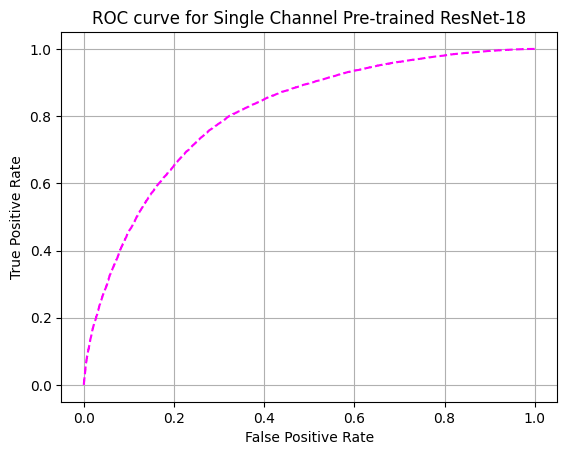

In [ ]:
plt.plot(fpr, tpr, "--", color="magenta")
#plt.plot([0,1],[0,1],"--")
plt.grid()
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC curve for Single Channel Pre-trained ResNet-18")
plt.show()

In [ ]:
path = "./gdrive/MyDrive/CMS_model/ResNet_single_channel_task1_weights.pth"
torch.save(model_ResNet18.state_dict(), path)

## VII. Conclusion

### Two-channel Input

Pre-trained ResNet-18 has the best performance on the electron/photon classfication dataset for two channel input:
1. Accuracy ~ 74.0 %
2. ROC-AUC score ~ 0.812

### Single Channel Input

Besides, if we only use the energy channel data, the model could have better or comparable performance.

1. LeNet: 

Accuracy: 71.9% (two-channel) vs 72.8% (single channel)

ROC-AUC score: 0.778 (two-channel) vs 0.793 (single channel)

2. SImplified ResNet (two ResBlock): 

Accuracy: 72.1% (two-channel) vs 72.4% (single channel)

ROC-AUC score: 0.786 (two-channel) vs 0.790 (single channel)

3. Pre-trained ResNet-18: 

Accuracy: 74.0% (two-channel) vs 74.0% (single channel)

ROC-AUC score: 0.812 (two-channel) vs 0.808 (single channel)

### Conclusion: 

In these three models, single channel input has better or at least comparable performance than two-channel input, which means the information of time channel is not well utilized.

### Further Directions:

Therefore, a good mixer of two channels might be needed, or we can apply parametric affine transformation on these two channels.

1. MLP-mixer

2. ResMLP